In [1]:
from __future__ import division   # impone aritmética no entera en la división
from PIL import Image             # Image Loading
import numpy as np                # Arrays, matrix
import pandas as pd               # Dataframes
import matplotlib.pyplot as plt   # Graphic representation
import cv2                        # Image transformation and matrix
import os                         # Working with the terminal
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
import tensorflow as tf           # For building the CNN
import keras                      # For building the CNN
import tensorflow.image as tfi    # Wotking with images in a TF adapted format
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D,  MaxPool2D, UpSampling2D, concatenate, Activation
from sklearn.model_selection import train_test_split # Splitting the data


import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Tensorflow Config

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#GPU growth, limiting memory to the minimun
#Preventing the OOM error

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu , True)

## Read the mask

Mask will be only 0 and 1 (True or False). We will use the mask only to measure if the result is correct

In [9]:
mask = Image.open(r"../benign/benign (1)_mask.png")
mask

FileNotFoundError: [Errno 2] No such file or directory: '../benign/benign (1)_mask.png'

## 1. Load Dataset

In [ ]:
#Folder Path
path = "Dataset_BUSI_with_GT/"

#Create clases 
types = []

for i in os.listdir(path):
    if i != '.DS_Store':
        types.append(i)

In [ ]:
types

['malignant', 'benign', 'normal']

In [ ]:
#Separate the directories, from masks and images

mask = []
image = []

for folder in types:
    i = os.path.join(path, folder)
    
    for pic in os.listdir(i):

        if "_mask" in pic:
            mask.append(os.path.join(i, pic))
            
        else:
            image.append(os.path.join(i, pic))


In [ ]:
len(image)

780

In [ ]:
cv2.imread(image[0], 0).shape


(571, 792)

# 2 Read Images & Rescale

In [ ]:
def rescale(picture):
    """ 
    Re-size the vectorize image/mask of the ultrasound to 250 x 250, 
    Rescale without padding, this can reduce the model accuracy
    """
    
    return tfi.resize(cv2.imread(picture), size= (256, 256)).numpy().astype(int)

Metal device set to: Apple M1


2023-04-20 18:48:52.128404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-20 18:48:52.128490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


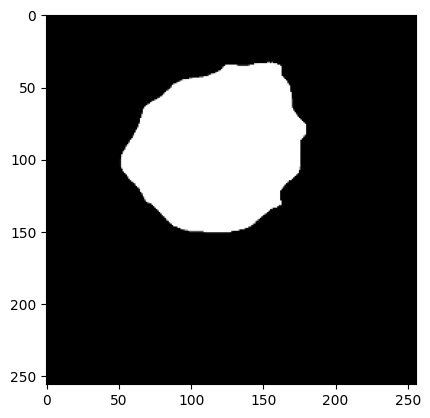

In [ ]:
# Rescale function testing
plt.imshow(rescale(mask[0]))

In [ ]:
df_img = pd.DataFrame(image, columns=['image'])
df_mask = pd.DataFrame(mask, columns=['mask'])

In [ ]:
df_mask = pd.DataFrame(df_mask['mask'].sort_values())
df_img = pd.DataFrame(df_img['image'].sort_values().reset_index(drop=True))

In [ ]:
df_mask.loc[0][0][-7:]

'ask.png'

In [ ]:
mask_dup = []
for i in df_mask['mask']:
    if i[-5] != '1' and i[-5] != '2':
        mask_dup.append(i)
    else:
        print(i)

Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (163)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (173)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (181)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (195)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (195)_mask_2.png
Dataset_BUSI_with_GT/benign/benign (25)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (315)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (346)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (4)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (424)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (54)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (58)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (83)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (92)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (93)_mask_1.png
Dataset_BUSI_with_GT/benign/benign (98)_mask_1.png
Dataset_BUSI_with_GT/malignant/malignant (53)_mask_1.png


In [ ]:
len(mask_dup)

780

In [ ]:
y = pd.DataFrame(mask_dup, columns=['mask'])

# 3. CNN Models

Decoding Unet, starting from the buttom, layer 16 and Pooling into 64 layer. Then start upsampling 

## 3.1 Train test

In [ ]:
X = [rescale(i) for i in df_img['image']]
X = np.array(X)

In [ ]:
X.shape

(780, 256, 256, 3)

In [ ]:
len(X)

780

In [ ]:
y = [rescale(x) for x in (y['mask'])]
y = np.array(y)

In [ ]:
len(y)

780

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.20)

In [ ]:
X_train.shape

(156, 256, 256, 3)

In [ ]:
y_train.shape

(156, 256, 256, 3)

In [ ]:
X_test.shape

(624, 256, 256, 3)

In [ ]:
y_train.shape

(156, 256, 256, 3)

In [ ]:
X_train.shape

(156, 256, 256, 3)

In [ ]:
y_train.shape

(156, 256, 256, 3)

Train test with normalization to 1 pixel, the max was 254

In [ ]:
X_train_grey = tf.image.rgb_to_grayscale(X_train) / 254
X_test_grey = tf.image.rgb_to_grayscale(X_test) / 254

In [ ]:
y_train_grey = tf.image.rgb_to_grayscale(y_train) / 254
y_test_grey = tf.image.rgb_to_grayscale(y_test) / 254

In [ ]:
X_train_grey[0].shape

TensorShape([256, 256, 1])

## 3.2 Models

Segmentation y classification convolutional networkd

In [ ]:
#Classification Model
model_classification = tf.keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(256, 256, 1)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(3,activation="softmax")
])

In [ ]:
# Segmentation model
model_segmentation = keras.models.Sequential([
    
    #image size = 256 * 256 * 1
    keras.layers.Conv2D(16, 1, padding='same', activation='relu', input_shape=(256, 256, 1)),
    keras.layers.Conv2D(16, 1, padding='same', activation='relu', input_shape=(256, 256, 1)),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(32, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(32, 1, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(64, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 1, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(128, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(128, 1, padding='same', activation='relu'),
    keras.layers.UpSampling2D(),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 1, padding='same', activation='relu'),
    keras.layers.UpSampling2D(),
    
    keras.layers.Conv2D(32, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(32, 1, padding='same', activation='relu'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Conv2D(16, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(16, 1, padding='same', activation='relu'),
    keras.layers.Conv2D(1, 1, activation='sigmoid')

])

## 3.3 Configuration for fitting

In [ ]:

train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    image_size=(256, 256),
    batch_size=32,
    seed=77,
    color_mode='grayscale', 
    subset='training',
    shuffle=True,
    validation_split=0.2
)

val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    image_size=(256, 256),
    seed=77,
    batch_size=32,
    color_mode='grayscale',
    subset='validation',
    shuffle=True,
    validation_split=0.2)

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.


In [ ]:
#To save all check points from the 
callbacks = [ keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True) ]

In [ ]:
callbacks_2 = [ keras.callbacks.ModelCheckpoint("image_classification2.h5", save_best_only=True) ]

## 3.4 Compilers

In [ ]:
model_segmentation.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_classification.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model_classification.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

## 3.5 Fits

In [ ]:
#Segmentation fit
model_segmentation.fit(X_train_grey, y_train_grey, epochs=25, batch_size=30, validation_data=(X_test_grey, y_test_grey), callbacks=callbacks)

Epoch 1/25


2023-04-20 18:49:03.009048: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-20 18:49:03.542357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.7443

2023-04-20 18:49:07.564238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 9s 1s/step - loss: 0.6188 - accuracy: 0.7443 - val_loss: 0.6561 - val_accuracy: 0.9186
Epoch 2/25
6/6 [==============================] - 7s 1s/step - loss: 0.4228 - accuracy: 0.9292 - val_loss: 0.5844 - val_accuracy: 0.9186
Epoch 3/25
6/6 [==============================] - 7s 1s/step - loss: 0.3174 - accuracy: 0.9336 - val_loss: 0.5209 - val_accuracy: 0.9186
Epoch 4/25
6/6 [==============================] - 7s 1s/step - loss: 0.3069 - accuracy: 0.9343 - val_loss: 0.5301 - val_accuracy: 0.9186
Epoch 5/25
6/6 [==============================] - 7s 1s/step - loss: 0.2836 - accuracy: 0.9345 - val_loss: 0.5398 - val_accuracy: 0.9186
Epoch 6/25
6/6 [==============================] - 7s 1s/step - loss: 0.2713 - accuracy: 0.9346 - val_loss: 0.5254 - val_accuracy: 0.9186
Epoch 7/25
6/6 [==============================] - 7s 1s/step - loss: 0.2634 - accuracy: 0.9346 - val_loss: 0.5000 - val_accuracy: 0.9186
Epoch 8/25
6/6 [==============================] - 7s

In [ ]:
#Classification fit
model_classification.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks_2)

Epoch 1/20


2023-04-20 18:51:59.372136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.8757 - accuracy: 0.5701

2023-04-20 18:52:04.663092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 6s 144ms/step - loss: 0.8757 - accuracy: 0.5701 - val_loss: 0.9089 - val_accuracy: 0.6698
Epoch 2/20
40/40 [==============================] - 6s 138ms/step - loss: 0.6734 - accuracy: 0.7031 - val_loss: 0.7477 - val_accuracy: 0.6825
Epoch 3/20
40/40 [==============================] - 6s 138ms/step - loss: 0.5797 - accuracy: 0.7340 - val_loss: 0.7154 - val_accuracy: 0.7016
Epoch 4/20
40/40 [==============================] - 6s 136ms/step - loss: 0.5023 - accuracy: 0.7799 - val_loss: 0.7332 - val_accuracy: 0.7302
Epoch 5/20
40/40 [==============================] - 6s 146ms/step - loss: 0.4220 - accuracy: 0.8124 - val_loss: 0.6316 - val_accuracy: 0.7810
Epoch 6/20
40/40 [==============================] - 6s 138ms/step - loss: 0.3564 - accuracy: 0.8543 - val_loss: 0.6450 - val_accuracy: 0.7746
Epoch 7/20
40/40 [==============================] - 6s 142ms/step - loss: 0.2490 - accuracy: 0.8987 - val_loss: 0.7592 - val_accuracy: 0.8000
Epoch 8/20
40/40 

## 3.6 Predicts

In [ ]:
#Segmentation predict
y_pred_segmentation = model_segmentation.predict(X_test_grey)

2023-04-20 18:53:54.832798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 201ms/step


In [ ]:
#Classification rpedict
y_pred_classification = model_classification.predict(X_test_grey)

 4/20 [=====>........................] - ETA: 0s

2023-04-20 18:53:59.035176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 42ms/step


In [ ]:
type(y_pred_classification)

numpy.ndarray

## 3.7 Models evaluation

### 3.7.1 Segmentation CNN evaluation

In [ ]:
#Model evaluation
model_segmentation.evaluate(X_test_grey, y_test_grey)

20/20 [==============================] - 4s 206ms/step - loss: 0.4048 - accuracy: 0.9186


[0.4047677516937256, 0.918580174446106]

### 3.7.2 Classification CNN evaluation

In [ ]:
#Sort by the tumor type name
class_names = np.array(sorted([item for item in types]))

In [ ]:
# Get "True" Lables for predicted variables
y_true = []
y_pred = []

for images, labels in val_generator:
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(model_classification.predict(images), axis=-1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 [==============================] - 0s 10ms/step


2023-04-20 18:54:04.398133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 78ms/step


2023-04-20 18:54:04.978571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
print('Matriz de confusión:')
print(cm)

# Calcular el F1-score y recall para cada clase
print('F1-score:')
print(f1_score(y_true, y_pred, average=None))
print('Recall:')
print(recall_score(y_true, y_pred, average=None))


Matriz de confusión:
[[161  12   6]
 [ 29  53   0]
 [ 10   3  41]]
F1-score:
[0.84960422 0.70666667 0.81188119]
Recall:
[0.89944134 0.64634146 0.75925926]


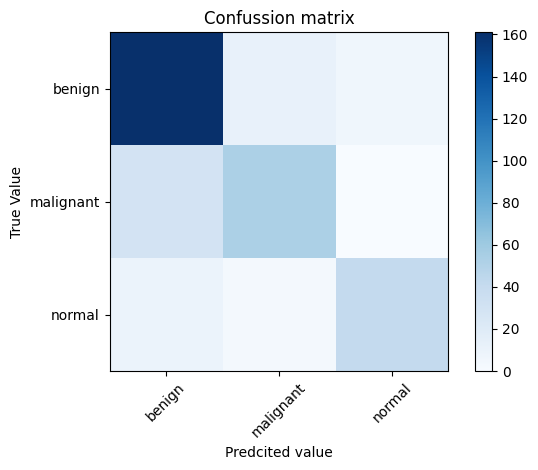

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confussion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Value')
    plt.xlabel('Predcited value')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=['clase 1', 'clase 2', 'clase 3'])


## Data Insights

In [ ]:
y_test_grey.shape

TensorShape([624, 256, 256, 1])

In [ ]:
np.prod(y_test_grey[500].numpy().shape)

65536

(array([    0.,     0.,     0.,     0.,     0., 65536.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

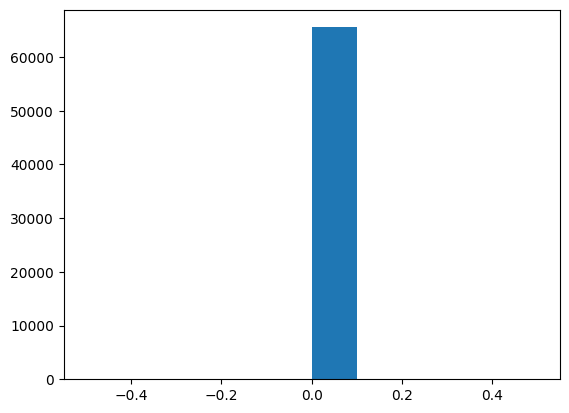

In [ ]:
plt.hist(y_test_grey[500].numpy().ravel())

In [ ]:
np.prod(y_test_grey.shape) 

40894464

In [ ]:
y_test_grey.numpy().sum() 

3285258.0866141715

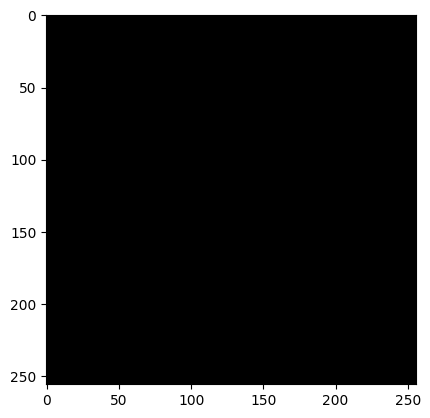

In [ ]:
plt.imshow(y_test[500])

## 4. Graphics

1/1 [==============================] - 0s 17ms/step


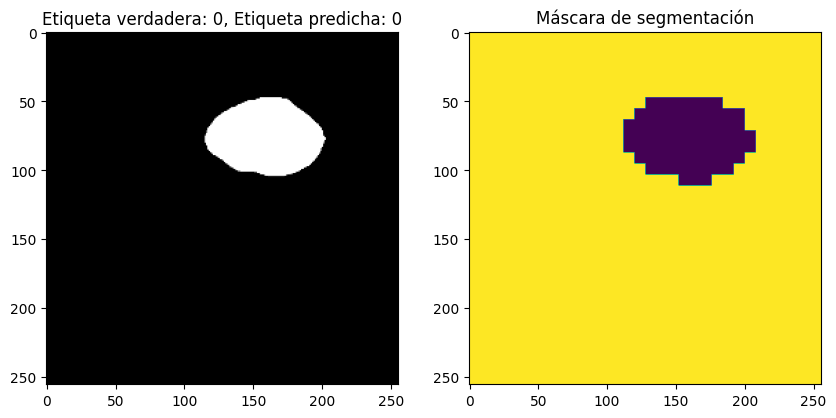

1/1 [==============================] - 0s 18ms/step


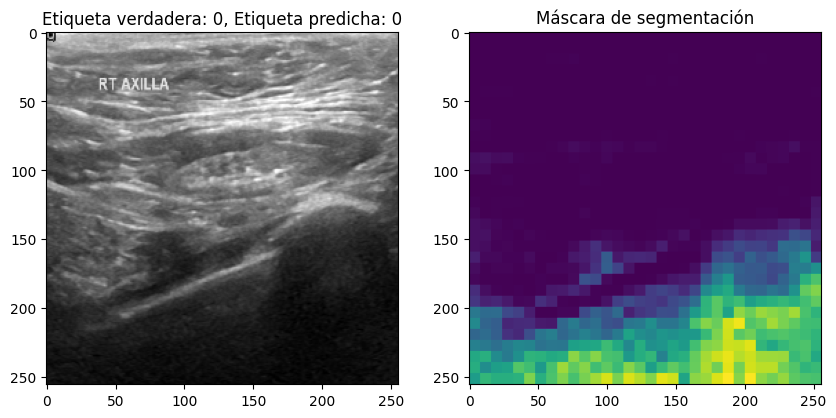

1/1 [==============================] - 0s 17ms/step


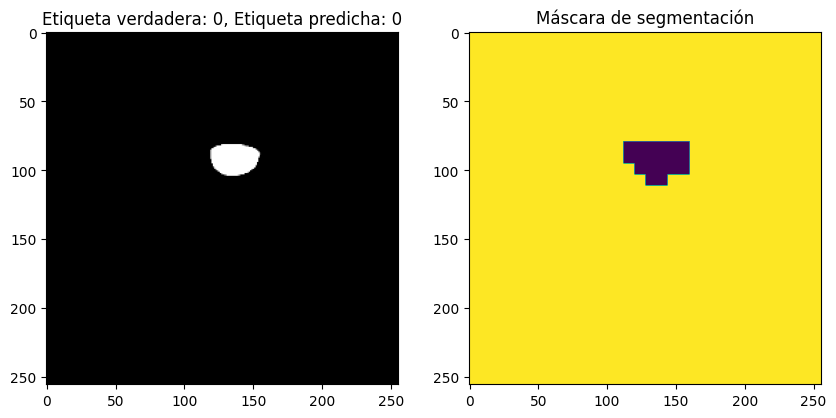

1/1 [==============================] - 0s 17ms/step


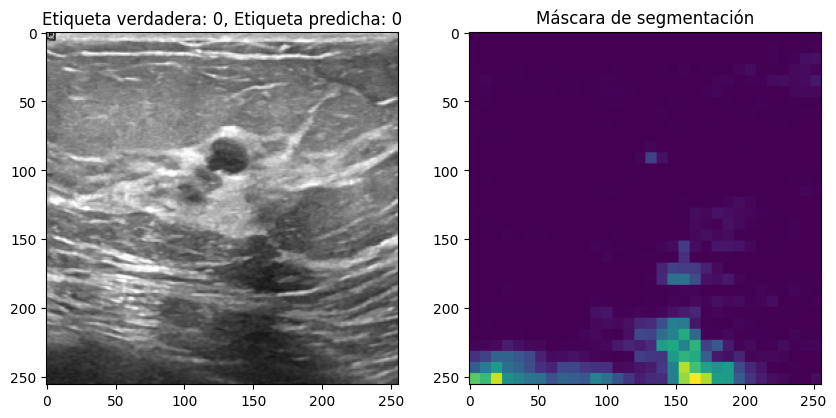

1/1 [==============================] - 0s 18ms/step


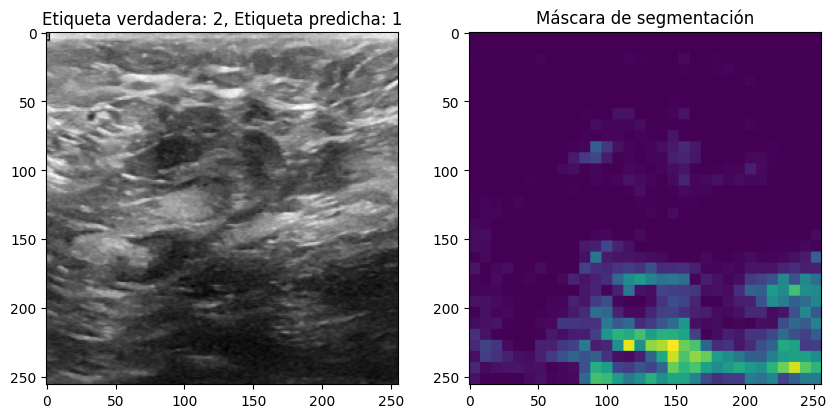

1/1 [==============================] - 0s 19ms/step


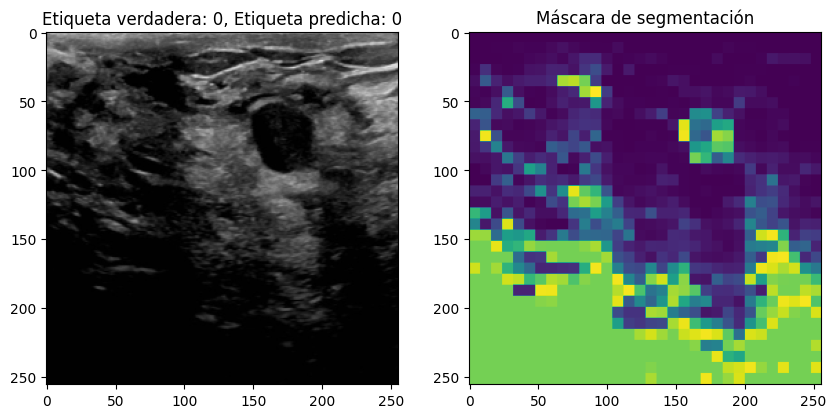

1/1 [==============================] - 0s 17ms/step


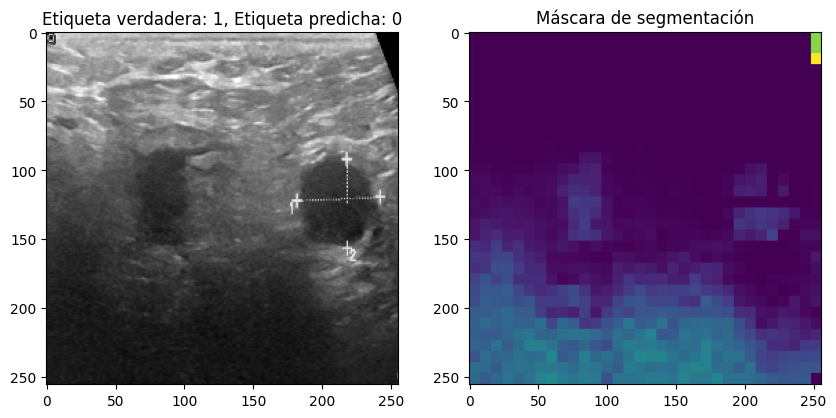

1/1 [==============================] - 0s 16ms/step


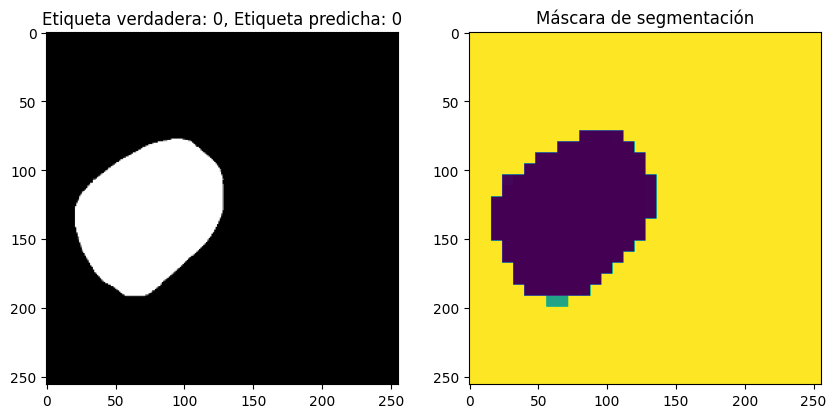

1/1 [==============================] - 0s 17ms/step


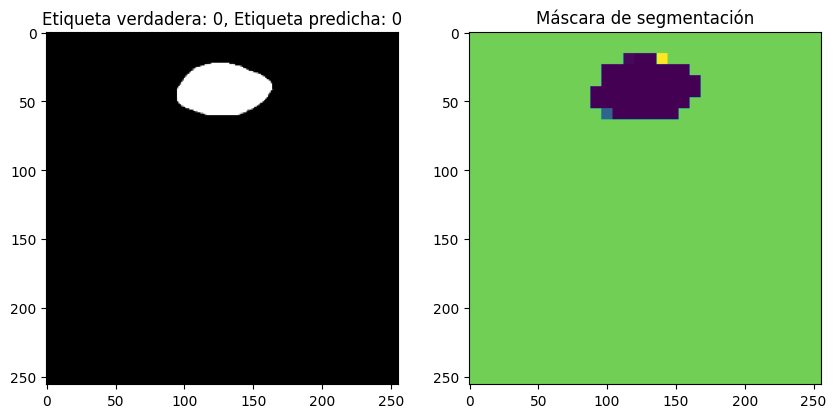

1/1 [==============================] - 0s 17ms/step


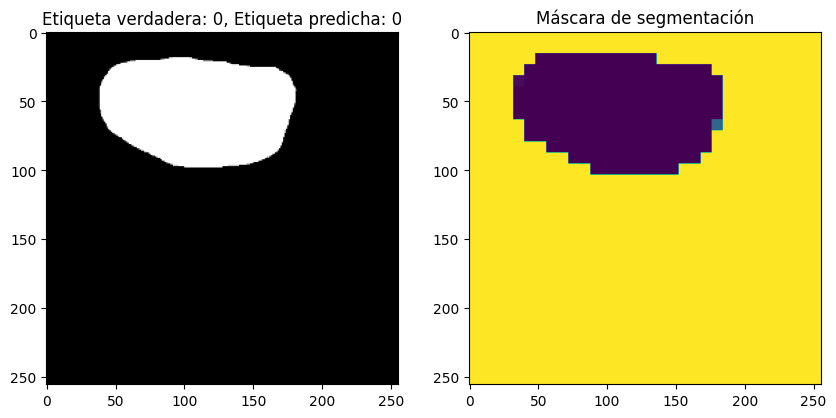

In [ ]:

for i in range(10):
    # Random image
    index = np.random.randint(len(val_generator))
    images, labels = list(val_generator)[index]
    image = images[0]
    label_true = labels.numpy()[0]
    
    #Label for Classification CNN
    label_pred = np.argmax(model_classification.predict(images), axis=-1)[0]
    
    #Label for Segmentation CNN
    mask = model_segmentation.predict(np.expand_dims(image, axis=0))[0]
    
    #Show images with labels
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image.numpy().reshape((256, 256)), cmap='gray')
    axs[0].set_title(f'Etiqueta verdadera: {label_true}, Etiqueta predicha: {label_pred}')
    axs[1].imshow(mask)
    axs[1].set_title('Máscara de segmentación')
    plt.show()